In [1]:
from nrs import NRS_Model, Element, NRS_Revision, NRS_Observer_E    # классы НРС
from nrs import NRS_Data as nd                                      # Табличные данные НРС
from nrs import q_out_simple, q_out_nozzle                          # модели расчета параметров
import matplotlib.pyplot as plt                                     # библиотеки для отрисовки получаемых данных

## Простая модель от одного насоса к одному стволу
![модель НРС](nrs_simple_1.jpg)


Схема НРС состоит из:
* 1 источника в виде насоса ПА
* 1 рабочей рукавной линии
* 1 прибора подачи воды

In [2]:
# Вычисляем проводимость насадка для ствола Б
p_nozzleB = NRS_Revision.calc_p(3.7, 40)
p_nozzleB

0.5850213671311502

In [3]:
# Создаем элементы НРС
pump = Element('Насос', e_type=0, H_add=20)                                 # Стартовый напор на насосе = 20м                     
hoseW1 = Element('РРЛ 1', e_type=1, s=nd.ss["51"], n=10)                    # Рукава 51мм, кол-во рукавов=10
nozzle1 = Element('Ствол 1', e_type=2, p=p_nozzleB, q_out = q_out_nozzle)   # Для ствола указываем проводимость расчитанную ранее (p_nozzleB) и метод расчета q_out_nozzle

# Соединяем элементы друг с другом Насос->Рукавная линия->Ствол
pump.append(hoseW1).append(nozzle1)

# Добавляем наблюдателей
watcher_pump = NRS_Observer_E(pump, ['q', 'H_add'])         # Для насоса. Наблюдаем изменения расхода и дополнительного напора (создаваемого насосом)
watcher_nozzle1 = NRS_Observer_E(nozzle1, ['q', 'H_in'])    # Для ствола. Наблюдаем изменения расхода и напора на входе

# Строим модель и инициируем обозревателей
model = NRS_Model('Простая модель от одного насоса к одному стволу')
model.build(pump, interpretate=True).observersInit()


Новый элемент НРС: Насос
Новый элемент НРС: РРЛ 1
Новый элемент НРС: Ствол 1
Новая модель: Простая модель от одного насоса к одному стволу


In [4]:
# Печатаем состав модели
NRS_Revision.print_model_elements(model)

all:
  Насос
  РРЛ 1
  Ствол 1
in:
  Насос
out:
  Ствол 1


In [5]:
# Печать предыдущего элемента для ствола nozzle1
NRS_Revision.print_previous_elements(nozzle1)

РРЛ 1


In [15]:
# Расчет
model.calc(accuracy=0.05)

(<nrs.NRS_Model at 0x20ff9c6f410>, 1)

In [16]:
print(model.summaryQ())

6.882155146329283


In [8]:
# Рассчитываем (для 10 итераций)
# model.calc(iters=10)

In [9]:
# Получаем текущий суммарный расход НРС
print(model.summaryQ())

2.16941691901252


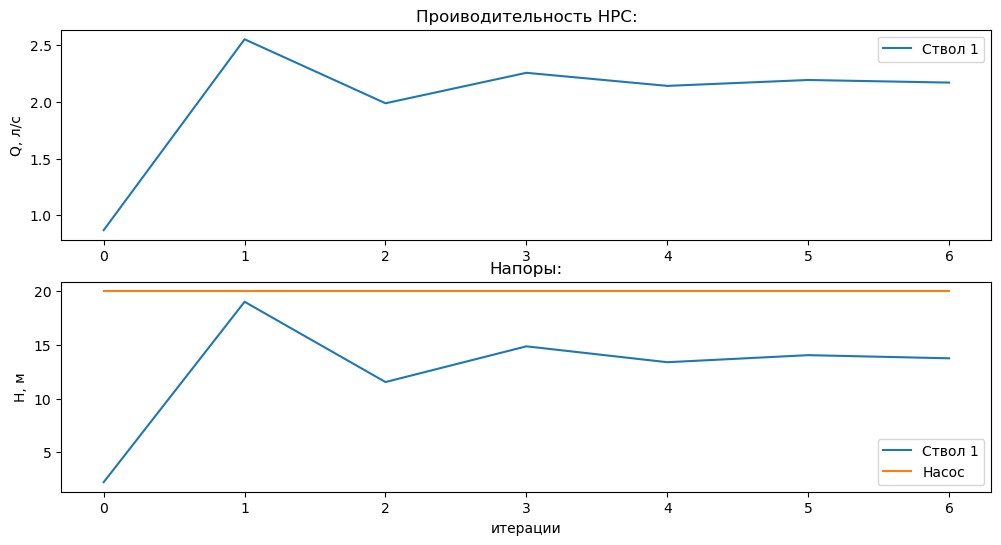

In [10]:
# Выведем графики
fig, axs = plt.subplots(2, 1, figsize=(12, 6))
axs[0].plot(watcher_nozzle1.history()['q'], label=nozzle1.name)
axs[0].set_title('Проиводительность НРС:')
axs[0].set_ylabel('Q, л/с')
axs[0].legend(fontsize=10)

axs[1].plot(watcher_nozzle1.history()['H_in'], label=nozzle1.name)
axs[1].plot(watcher_pump.history()['H_add'], label=pump.name, )
axs[1].set_title('Напоры:')
axs[1].set_xlabel('итерации')
axs[1].set_ylabel('Н, м')
axs[1].legend(fontsize=10)
plt.show()

In [11]:
# Постепенно повысим напоры на насосе. Сначала до 40м, затем до 80м. Для каждого повышения проведем расчет на 10 итерациях.
pump.set_H_add(40)
model.calc(10)
print(model.summaryQ())
pump.set_H_add(80)
model.calc(10)
print(model.summaryQ())

3.0778386402748397
4.352723255349221


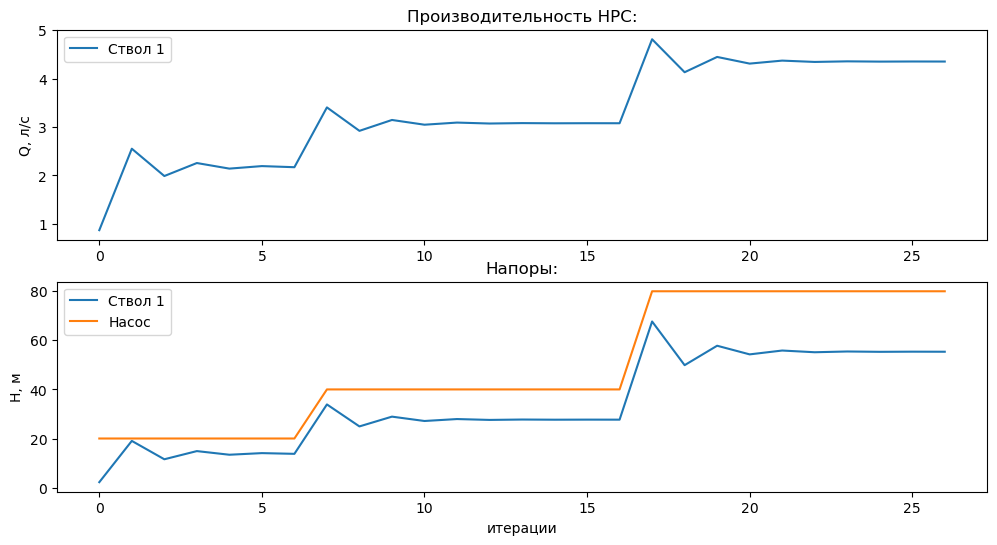

In [12]:
# Выведем графики
fig, axs = plt.subplots(2, 1, figsize=(12, 6))
axs[0].plot(watcher_nozzle1.history()['q'], label=nozzle1.name)
axs[0].set_title('Производительность НРС:')
axs[0].set_ylabel('Q, л/с')
axs[0].legend(fontsize=10)

axs[1].plot(watcher_nozzle1.history()['H_in'], label=nozzle1.name)
axs[1].plot(watcher_pump.history()['H_add'], label=pump.name, )
axs[1].set_title('Напоры:')
axs[1].set_xlabel('итерации')
axs[1].set_ylabel('Н, м')
axs[1].legend(fontsize=10)
plt.show()

## Расчет до достижения необходимой точности

In [13]:
# Сбрасываем историю расчета
# model.observersInit()

# Устанавливаем напор на насосе
pump.set_H_add(200)
# Рассчитываем для точности 0.005л/с
_, iters_count = model.calc(accuracy=0.005)
print("Итоговый расход: {} л/с".format(model.summaryQ()))
print("Потребовалось итераций: {}".format(iters_count))

Итоговый расход: 6.884193742599869 л/с
Потребовалось итераций: 9


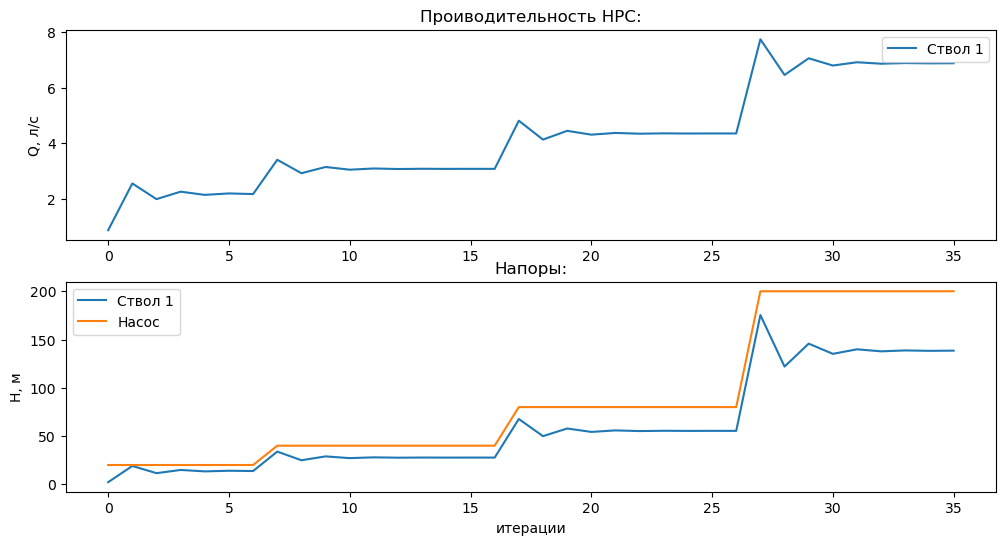

In [14]:
# Выведем графики
fig, axs = plt.subplots(2, 1, figsize=(12, 6))
axs[0].plot(watcher_nozzle1.history()['q'], label=nozzle1.name)
axs[0].set_title('Проиводительность НРС:')
axs[0].set_ylabel('Q, л/с')
axs[0].legend(fontsize=10)

axs[1].plot(watcher_nozzle1.history()['H_in'], label=nozzle1.name)
axs[1].plot(watcher_pump.history()['H_add'], label=pump.name, )
axs[1].set_title('Напоры:')
axs[1].set_xlabel('итерации')
axs[1].set_ylabel('Н, м')
axs[1].legend(fontsize=10)
plt.show()